## Project Objective: AUTOMATIC TICKET ASSIGNMENT

In [1]:
# !pip install openpyxl
# !pip install tabulate
# !pip install langdetect
# !pip install flake8 pycodestyle_magic
# !pip install textblob
# !pip install pycountry
# !pip install spacy_cld
# !pip install fasttext
# !pip install fastlangid
# !pip install plotly
# !pip install chart_studio
# %reset
# !pip install wordcloud
#!pip install wordcloud
# !pip install lightgbm
# !pip install -U gensim
# !pip install yellowbrick

### Process Flow
1. Import Data
2. Explore Data, check for any inconsitancy
3. Remove redundant data from short Description and Description.
4. detect language of description.
5. EDA and Visulization
7. Drop duplicates based on shot description , description and assignment group
8. tokenize data and remove stop words.
9. create corpus for Description and combined Description.



In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
##################################################
# File: Autometic Ticket Assignment
# Author: Manasi Hiremath
# Date: 31-Aug-21
# Purpose: NLP based Ticket Assignment
# Input : Input.xlsx 
# Output:Predictive model to automate ticket assignment
# Total Execution Time:495.24 second(s)
##################################################

In [4]:
# Check PEP8 Standards
# %reload_ext pycodestyle_magic
# %pycodestyle_on

In [5]:
# ===================== Step 1: Import library =================
import pandas as pd
import numpy as np
import os
import openpyxl
import re
import time
from langdetect import detect
from textblob import TextBlob
import pytz
from fastlangid.langid import LID
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import logging
import nltk
import string
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
nltk.download('stopwords')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#===================== Step 2: Logging =================
# logging.basicConfig(filename='NLP_Capstone_Project.log', level=logging.DEBUG,
#                     format='%(process)d| %(asctime)s | %(name)s | %(levelname)s | %(message)s')
# logging.warning('This will get logged to a file')
# logging.info('This will get logged to a file')

In [7]:
# ===================== Step 3: Processing =================
def func_read_data_n_explore(path):
    '''
    This Function takes input excel file, converts it into pandas dataframe and carry out intial data exploration
    input parameter: input file path
    output parameter: Summary of Data exploration and output pandas dataframe
    '''
    temp_01 = pd.read_excel(path, engine='openpyxl')
    data_with_missing_obs = [x for x in temp_01.columns if len(temp_01[temp_01[x].isnull()]) >= 1]
    print('Data Summary')
    print('')
    print('1.Shape of Data:{}'.format(temp_01.shape))
    print('')
    print('2.Display if column has null values:{}'.format(data_with_missing_obs))
    print('')
    print('3.Display count of missing data :{}'.format(temp_01.isnull().sum()))
    print('')
    for i in range(len(data_with_missing_obs)):
        print("4.{} Sample of missing column:{}".format(i, data_with_missing_obs[i]))
        print('****************')
        temp_02 = temp_01[temp_01[data_with_missing_obs[i]].isnull()]
        print(temp_02.head())
        print('')
    return temp_01


def func_remov_special_char(text):
    '''
    Remove Special Characters from text
    input: text. i.e dataframe column values
    output: clean text
    '''
    try:
        return re.sub(r"[^a-zA-Z]", " ", text)
    except Exception:
        return ''

def func_remov_disclaimer(text):
    '''
    Remove Disclaimer from text
    input: text. i.e dataframe column values
    output: clean text
    '''
    try:
        return re.sub(r"select the following link to view the disclaimer in an alternate language. ","", text)
    except Exception:
        return ''


def func_clean_data(temp_02):
    # Remove new line characters
    temp_02['Description'] = temp_02['Description'].apply(func_remov_disclaimer)
    temp_02['Short description'] = temp_02['Description'].apply(func_remov_disclaimer)    
    remove_char_list = ['_x000D_\n', '_x000D_\n_x000D_\n','received from:', r"\S*@\S*\s", '\n']
    temp_02['Description'] = temp_02['Description'].replace(remove_char_list, '', regex=True)
    temp_02['Short description'] = temp_02['Short description'].replace(remove_char_list, '', regex=True)
    temp_02['Short description'] = temp_02['Short description'].apply(func_remov_special_char)
    temp_02['Description'] = temp_02['Description'].apply(func_remov_special_char)
    # Remove caller name from description
    temp_03 = pd.DataFrame(temp_02.Caller.str.split(' ', 2).tolist(),columns=['FirstName', 'LastName'])
    temp_03.update(temp_03[['FirstName', 'LastName']].applymap('{}'.format))
    for name in range(len(temp_03)):
        temp_02['Description'] = temp_02['Description'].str.replace(temp_03['FirstName'][name], '')
        temp_02['Description'] = temp_02['Description'].str.replace(temp_03['LastName'][name], '')
        temp_02['Short description'] = temp_02['Short description'].str.replace(temp_03['FirstName'][name], '')
        temp_02['Short description'] = temp_02['Short description'].str.replace(temp_03['LastName'][name], '')
    # strip white space
    temp_02[temp_02.columns] = temp_02.apply(lambda x: x.str.strip())
    #remove extra space between words
    temp_02['Description'] = [(" ".join(temp_02['Description'][x].split())) for x in range(len(temp_02))]
    temp_02['Short description'] = [(" ".join(temp_02['Short description'][x].split())) for x in range(len(temp_02))]
    return temp_02


# Funtion to detect text language
def func_detect_text_language(text):
    '''
    This function is used to detect the language of the text
    input parameter: text
    Output value": language of the text
    '''
    try:
        return detect(text)
    except Exception:
        return 'unknown'


def func_vis01_target_analysis(temp05):
    '''
    This Function creates visualization.
    input: processed input data
    output visulizations
    '''
    # Assignment Column analysis
    temp06 = temp05.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
    temp06 = temp06.sort_values(by='Total_Count', axis=0, ascending=False)
    temp06['Ticket_Contribution'] = round((temp06['Total_Count']/temp06['Total_Count'].sum())*100, 2)
    # Check Contirbution of each assignemt group
    fig = px.bar(temp06, x='Assignment group', y='Ticket_Contribution', title="Ticket Contribution by Assignment Group",
                 hover_data=['Assignment group', 'Total_Count', 'Ticket_Contribution'])
    fig.show()
    
    prod_list_with_small_data=temp06[temp06['Total_Count'] <2 ][['Assignment group', 'Total_Count']]
    print(prod_list_with_small_data)
    
    temp06 = temp05.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
    temp06 = temp06.sort_values(by='Total_Count', axis=0, ascending=False)
    temp06['Ticket_Contribution'] = round((temp06['Total_Count']/temp06['Total_Count'].sum())*100, 2)
    # Check Contirbution of each assignemt group
    fig = px.bar(temp06, x='Assignment group', y='Ticket_Contribution', title="Ticket Contribution by Assignment Group",
                 hover_data=['Assignment group', 'Total_Count', 'Ticket_Contribution'])
    fig.show()
    
    # Language analysis
    temp07 = temp05.groupby(['Language_name'])['Language_name'].count().to_frame('Total_Count').reset_index()
    temp07 = temp07.sort_values(by='Total_Count', axis=0, ascending=False)
    temp07['Language_used'] = round((temp07['Total_Count']/temp07['Total_Count'].sum())*100, 2)
    # Check Contirbution of each assignemt group
    fig = px.bar(temp07, x='Language_name', y='Language_used', title="Distribution of Languages used by caller",
                 hover_data=['Language_name', 'Total_Count', 'Language_used'])
    fig.show()
    # Languages contribution within assingment Group
    temp08 = temp05.groupby(['Assignment group','Language_name'])['Assignment group'].count().to_frame('Total_Count').reset_index()
    temp08 = temp08.sort_values(by='Total_Count', axis=0, ascending=False)
    temp08['Ticket_Contribution'] = round((temp08['Total_Count']/temp08['Total_Count'].sum())*100, 2)
    fig = px.bar(temp08, x='Assignment group', y='Ticket_Contribution', title="Languages used in Assignment Group",
                 hover_data=['Assignment group', 'Total_Count', 'Ticket_Contribution'], color='Language_name')
    fig.show()
    # Checking length of ticket short descriptions
    result = [len(x) for x in temp05['Short description']]
    print('Sample Length of ticket Short Description:',result[0:10])
    print('Maximum ticket Description length:',np.max(result))
    print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
    fig = px.box(y=result,title="Length Distribution of Short description of ticket")
    fig.show()
    
    # Checking length of ticket descriptions
    result = [len(x) for x in temp05['Description']]
    print('Sample Length of ticket Short Description:',result[0:10])
    print('Maximum ticket Description length:',np.max(result))
    print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
    fig = px.box(y=result,title="Length Distribution of ticket Description")
    fig.show()
    return None


stop_words=nltk.corpus.stopwords.words('english')+ list(string.punctuation)
def func_doc_preprocess(doc):
    '''
    This function tokenize text data.
    Removes stop words from text.
    input parameter: doc: text 
    output parameter: corpus of token
    '''
    doc = re.sub(r'[^a-zA-Z\s^\D]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    ## tokenize the document
    tokens= nltk.word_tokenize(doc)
    #remove stop words
    wordList = [token for token in tokens if token not in stop_words and not token.isdigit()]
    # re-create document from filtered tokens
    doc = ' '.join(wordList)
    return doc

def func_feature_importance_by_class(data,corpus):
    '''
    This function proviesd important features for each assignement group.
    input parameter: data: clean input data.
                     Corpus:tokenize data
    ouput: provides important features for each traget class.
    '''
    dummy_vars=pd.get_dummies(data['Assignment group'])
    data_10=pd.concat([data,dummy_vars], axis=1)
    
    # tf_idf
    vectorizer = TfidfVectorizer(stop_words ='english', 
                              ngram_range = (1,3), 
                              max_df = .6, min_df = .01,
                              sublinear_tf=True)
    X = vectorizer.fit_transform(corpus)
    X=X.toarray()
    feature_names = vectorizer.get_feature_names()
    tfidf = pd.DataFrame(np.round(X, 3), columns=feature_names)
    
    model = ExtraTreesClassifier()
    feat_importances_df=pd.DataFrame()
    # create a var name
    for i in range(len(data['Assignment group'].unique())):
        var='GRP'+'_'+str(i)
        labels=data_10[var]
        model.fit(tfidf, labels)
        feat_importances = pd.DataFrame(model.feature_importances_,
                                    index=vectorizer.get_feature_names(),
                                    columns=['feature_importances'])
        feat_importances.reset_index(inplace=True)
        feat_importances.rename(columns={"index": "features"})
        feat_importances['Target_class']=var
        feat_importances1=feat_importances.sort_values(by=['Target_class','feature_importances'], ascending=False).head(10)
        print("\n==> " ,var)
        print("  * Most Correlated terms are: %s" %(', '.join(feat_importances1['index'])))

    
    return tfidf

def train_test_fit(model, X_train, X_test, y_train, y_test): 
    '''
    This function fits the given model and score its performance
    input parameter:model : specify classification algorithm for experiment
                    X_train : Feature train data
                    X_test : Feature test data
                    y_train : Labels train data
                    y_test : Labels test data
    Output parameter:y_pred: predicted lables
                     score: model score for test data
                     recall
                     precision
                     f1_score
                     duration    
    '''
    start = time.time()
    model.fit(X_train, y_train)   # fit the model with the train data
    y_pred = model.predict(X_test)  # make predictions on the test set
    score = round(model.score(X_test, y_test), 3)   # compute accuracy score for test set
    
    recall=metrics.recall_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred))
    precision=metrics.precision_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred))
    f1_score= round(metrics.f1_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred)),3)
    end = time.time()
    duration = end - start  # calculate the total duration
    
    return y_pred,score, recall, precision,f1_score,duration   # return all the metrics


def model_training(classfierdict, X_train, X_test, y_train, y_test,iteration_det):
    '''
    This function creates a table with scoring metric
    input parameter:classfierdict : specify classification algorithm for experiment
                    X_train : Feature train data
                    X_test : Feature test data
                    y_train : Labels train data
                    y_test : Labels test data
    Output parameter:scoring_metric: scoring metric table
    '''
    scoring_metric=pd.DataFrame()
    scoring_metric_fl=pd.DataFrame()
    model_name_list= []
    score_list = []
    recall_list=[]
    precision_list=[]
    f1_score_list=[]
    elapsed=[]
    y_pred_list=[]
    cm=[]
    
    for i in classfierdict['model']:
        y_pred,score, recall, precision,f1_score,duration=train_test_fit(i,X_train, X_test, y_train, y_test)
        y_pred_list.append(y_pred)
        model_name_list.append(i)
        score_list.append(score)
        recall_list.append(recall)
        precision_list.append(precision)
        f1_score_list.append(f1_score)
        elapsed.append(duration)
        Model_name='model'+'_'+re.sub("[\(\[].*?[\)\]]", "", str(i))        
        
    scoring_metric = pd.DataFrame({'iteration': iteration_det,
                                   'Model':model_name_list,
                                   'Model_score':score_list,
                                   'Model_recall':recall_list,
                                   'Model_precision':precision_list,
                                   'Model_f1_score':f1_score_list,
#                                    'Model_roc_auc':roc_auc_list,
                                   'Elapsed': elapsed})
    scoring_metric['Model_name']= scoring_metric['Model'].astype('str').map(lambda x:re.sub("[\(\[].*?[\)\]]", "", x))   
    return scoring_metric  # return all the metrics


def func_tfidx_metric(corpus,model_data):
    '''
    This function creates a tfidx matrix
    input parameter:corpus : corpus 
                    model_data : analysis data
    Output parameter:scoring_metric: scoring metric table
    '''
    vectorizer = TfidfVectorizer(stop_words ='english', 
                              ngram_range = (1,3), 
                              max_df = .6, min_df = .01,
                              sublinear_tf=True)
    X = vectorizer.fit_transform(corpus)
    X=X.toarray()
    feature_names = vectorizer.get_feature_names()
    tfidf = pd.DataFrame(np.round(X, 3), columns=feature_names)
    X_tr, X_te, y_tr, y_te = train_test_split(
                                            tfidf, model_data['Assignment group'],
                                            test_size=0.1, random_state=10, 
                                             stratify=model_data['Assignment group'])
    return X_tr, X_te, y_tr, y_te


def func_feature_selection_pca(X_tr, X_te):
    '''
    This function selects features based on pca
    input parameter: X_tr : train features 
                     X_te : test features 
    Output parameter:X_tr_pca:selected train features
                     X_te_pca:selected test features
    '''    
    pca = PCA(0.95)
    pca.fit(X_tr)
    X_tr_pca = pca.transform(X_tr)
    X_te_pca = pca.transform(X_te)
    return X_tr_pca, X_te_pca


def func_feature_selection_chi(X_tr, y_tr, X_te):
    '''
    This function selects features using chisquare
    input parameter: X_tr : train features 
                     X_te : test features
                     y_tr : train label
    Output parameter:X_tr_chi2:selected train features
                     X_te_chi2:selected test features
    ''' 
    ch2 = SelectKBest(chi2, k=100)
    X_tr_chi2 = ch2.fit_transform(X_tr,y_tr)
    X_te_chi2 = ch2.transform(X_te)
    return X_tr_chi2, X_te_chi2

In [8]:
start = time.perf_counter()
print('Step 1. Getting Input Data Information...')
temp_03 = func_read_data_n_explore("input_data.xlsx")

Step 1. Getting Input Data Information...
Data Summary

1.Shape of Data:(8500, 4)

2.Display if column has null values:['Short description', 'Description']

3.Display count of missing data :Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

4.0 Sample of missing column:Short description
****************
     Short description                                        Description  \
2604               NaN  _x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...   
3383               NaN  _x000D_\n-connected to the user system using t...   
3906               NaN  -user unable  tologin to vpn._x000D_\n-connect...   
3910               NaN  -user unable  tologin to vpn._x000D_\n-connect...   
3915               NaN  -user unable  tologin to vpn._x000D_\n-connect...   

                 Caller Assignment group  
2604  ohdrnswl rezuibdt           GRP_34  
3383  qftpazns fxpnytmk            GRP_0  
3906  awpcmsey ctdiuqwe            GRP_0  
3910 

In [9]:
print("Step 2. Data Cleaning has started...")
temp_04 = func_clean_data(temp_03)
print("Step 3. Detecting text language...")
temp_04['text_lang'] = temp_04['Description'].apply(func_detect_text_language)
# Get language name
lang = pd.read_csv('language-codes_csv.csv')
temp_05 = pd.merge(temp_04, lang, left_on='text_lang', right_on='alpha2', how='left') 
print("Step 4. Data Explorarion...")
print('')
print('Data has - {} - ticket assignment groups'.format(len(temp_03['Assignment group'].unique())))
print('')
print('Tickets are registered in - {} languages '.format(len(temp_04['text_lang'].unique()))) 
print('')
func_vis01_target_analysis(temp_05)
print('Step 4.1. NLP preprocessing')

Step 2. Data Cleaning has started...
Step 3. Detecting text language...
Step 4. Data Explorarion...

Data has - 74 - ticket assignment groups

Tickets are registered in - 31 languages 



   Assignment group  Total_Count
61           GRP_64            1
58           GRP_61            1
64           GRP_67            1
29           GRP_35            1
68           GRP_70            1
71           GRP_73            1


Sample Length of ticket Short Description: [188, 128, 24, 29, 11, 46, 131, 62, 36, 24]
Maximum ticket Description length: 6462
Mean 142.67 words (324.279703)


Sample Length of ticket Short Description: [188, 128, 24, 29, 11, 46, 131, 62, 36, 24]
Maximum ticket Description length: 6462
Mean 142.67 words (324.279703)


Step 4.1. NLP preprocessing


In [23]:
temp_05.loc[:,'combined_description']=temp_05['Short description'].astype(str)+' '+temp_05['Description'].astype(str)
print(temp_05.shape)
temp_06=temp_05.drop_duplicates(['Short description','Description','Assignment group'])
print(temp_06.shape)

(8500, 8)
(6659, 8)


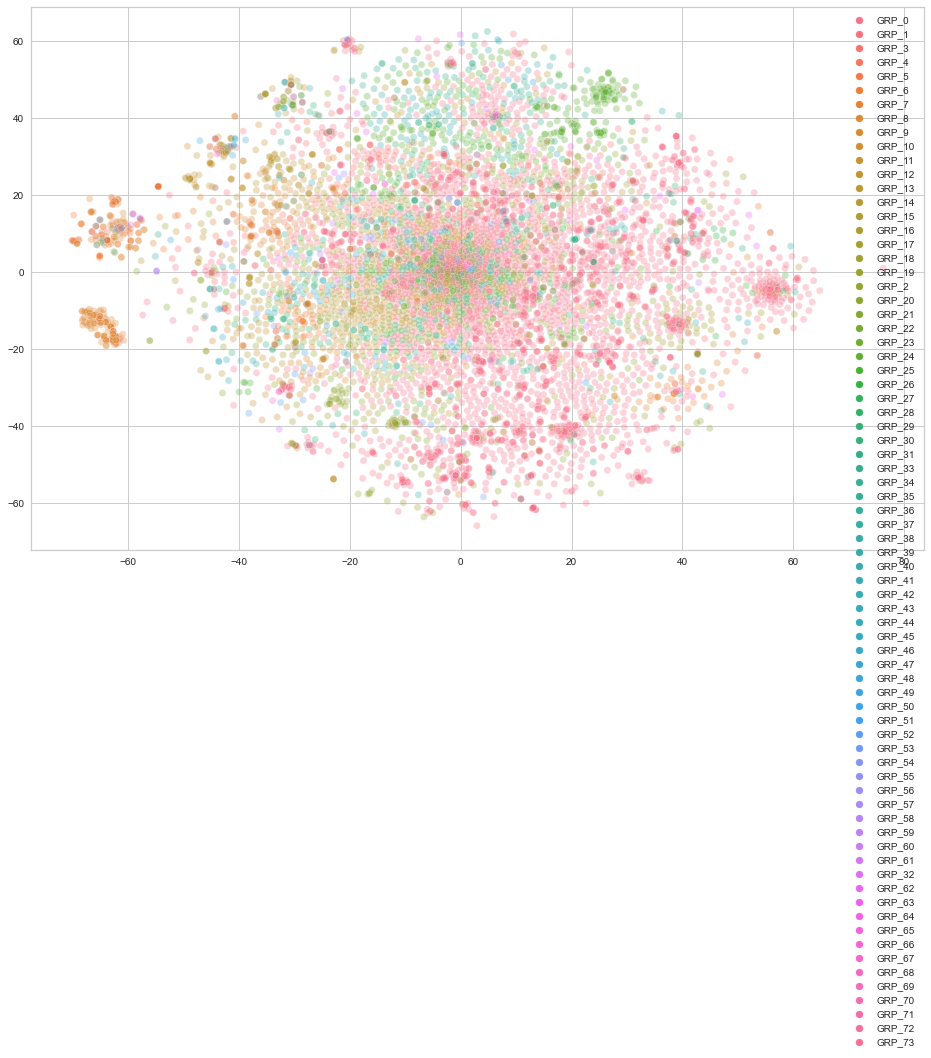

In [35]:
#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_06['Description']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus_model)

from sklearn.manifold import TSNE
import gc
gc.collect()
# tfIdfMatrix = tfIdfMat.todense()
labels = temp_06['Assignment group'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(X)
plt.figure(figsize=(16,10))
# palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
#     palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [36]:
# sns.scatterplot(
#     x=tsne_results[:,0], y=tsne_results[:,1],
#     hue=labels,
# #     palette= palette,
#     legend="full",
#     alpha=0.3
# )

fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=labels)
fig.show()

In [33]:
tsne_results.shape

(3532, 2)

In [84]:
temp_11= temp_06[temp_06['Assignment group'] != 'GRP_0']
# temp_11=temp_06.copy()
temp_11.head(2)

#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_11['Description']
vectorizer = TfidfVectorizer(stop_words='english')
X_sub = vectorizer.fit_transform(corpus_model)

clusters = KMeans(4, n_init = 30, algorithm='auto')
clusters.fit(X_sub)
x_pred_2=clusters.predict(X_sub)


# # print(score)
data=temp_11.copy()
data['clust_group']=x_pred_2

from sklearn.manifold import TSNE
import gc
gc.collect()
# tfIdfMatrix = tfIdfMat.todense()
labels = data['clust_group'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(X_sub)

In [85]:
fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=labels)
fig.show()

In [86]:
data['clust_group'].value_counts()

2    3024
1     207
3     178
0     123
Name: clust_group, dtype: int64

In [96]:
temp_12= temp_06[temp_06['Assignment group'] == 'GRP_0']
temp_12['clust_group']=4
# temp_12

<ipython-input-96-579c5097f0ba>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
temp_13= pd.concat([temp_12,data], axis=0)
temp_13['clust_group'].value_counts()

4    3127
2    3024
1     207
3     178
0     123
Name: clust_group, dtype: int64

In [101]:
#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_13['Description']
vectorizer = TfidfVectorizer(stop_words='english')
X_sub = vectorizer.fit_transform(corpus_model)

# clusters = KMeans(4, n_init = 30, algorithm='auto')
# clusters.fit(X_sub)
# x_pred_2=clusters.predict(X_sub)


# # # print(score)
# data1=temp_13.copy()
# data1['clust_group']=x_pred_2

from sklearn.manifold import TSNE
import gc
gc.collect()
# tfIdfMatrix = tfIdfMat.todense()
labels = temp_13['clust_group'].astype('category').to_list()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(X_sub)

In [99]:
fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=labels)
fig.show()

In [102]:
temp_13['clust_group'].value_counts()

4    3127
2    3024
1     207
3     178
0     123
Name: clust_group, dtype: int64

In [119]:
cluster_list=[0,1,2,3,4]
temp_14 = temp_13[temp_13['clust_group'].isin(cluster_list)]
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_14['Description']
vectorizer = TfidfVectorizer(stop_words='english')
X_sub = vectorizer.fit_transform(corpus_model)

vectorizer = TfidfVectorizer(stop_words ='english', 
                              ngram_range = (1,3), 
                              max_df = .6, min_df = .01,
                              sublinear_tf=True)
X = vectorizer.fit_transform(corpus_model)
X=X.toarray()
feature_names = vectorizer.get_feature_names()
tfidf = pd.DataFrame(np.round(X, 3), columns=feature_names)
X_tr, X_te, y_tr, y_te = train_test_split(
                                            tfidf, temp_14['clust_group'],
                                            test_size=0.1, random_state=10, 
                                             stratify=temp_14['clust_group'])
classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

Step 6. Model Execution...


iteration                                              Model  Model_score  \
0     tfidf                                    MultinomialNB()        0.608   
1     tfidf             LogisticRegression(solver='liblinear')        0.641   
2     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.614   
3     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.657   
4     tfidf  LGBMClassifier(objective='multiclass', random_...        0.648   

   Model_recall  Model_precision  Model_f1_score   Elapsed  \
0      0.758403         0.579380           0.623  0.028669   
1      0.690217         0.603379           0.598  0.366495   
2      0.638112         0.588895           0.596  0.146400   
3      0.663265         0.629969           0.606  1.252454   
4      0.648148         0.624683           0.598  3.322767   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [116]:
X_tr_pca, X_te_pca = func_feature_selection_pca(X_tr_tfidf, X_te_tfidf)
classfierdict={'model': [
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_pca, X_te_pca, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

Step 6. Model Execution...


iteration                                              Model  Model_score  \
0     tfidf             LogisticRegression(solver='liblinear')        0.636   
1     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.614   
2     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.631   
3     tfidf  LGBMClassifier(objective='multiclass', random_...        0.638   

   Model_recall  Model_precision  Model_f1_score    Elapsed  \
0      0.709193         0.628243           0.609   3.302690   
1      0.620748         0.569546           0.587   0.112673   
2      0.663717         0.591542           0.571   3.717560   
3      0.644558         0.582417           0.572  13.036508   

               Model_name  
0      LogisticRegression  
1    KNeighborsClassifier  
2  RandomForestClassifier  
3          LGBMClassifier

In [118]:
X_tr_chi2, X_te_chi2 = func_feature_selection_chi(X_tr_tfidf, y_tr_tfidf, X_te_tfidf)
classfierdict={'model': [
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_chi2, X_te_chi2, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

Step 6. Model Execution...


iteration                                              Model  Model_score  \
0     tfidf             LogisticRegression(solver='liblinear')        0.603   
1     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.266   
2     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.593   
3     tfidf  LGBMClassifier(objective='multiclass', random_...        0.609   

   Model_recall  Model_precision  Model_f1_score   Elapsed  \
0      0.730612         0.588551           0.600  0.171165   
1      0.273830         0.557165           0.339  0.135579   
2      0.598639         0.538732           0.540  0.373115   
3      0.632867         0.576420           0.570  1.235006   

               Model_name  
0      LogisticRegression  
1    KNeighborsClassifier  
2  RandomForestClassifier  
3          LGBMClassifier

In [25]:
# Get Total count by assignment group
temp_11= temp_06[temp_06['Assignment group'] != 'GRP_0']
temp_11.head(2)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


# true_k = 10
# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# model.fit(X)

# print("Top terms per cluster:")
# order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()
# for i in range(true_k):
#     print("Cluster %d:" % i),
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind]),
#     print

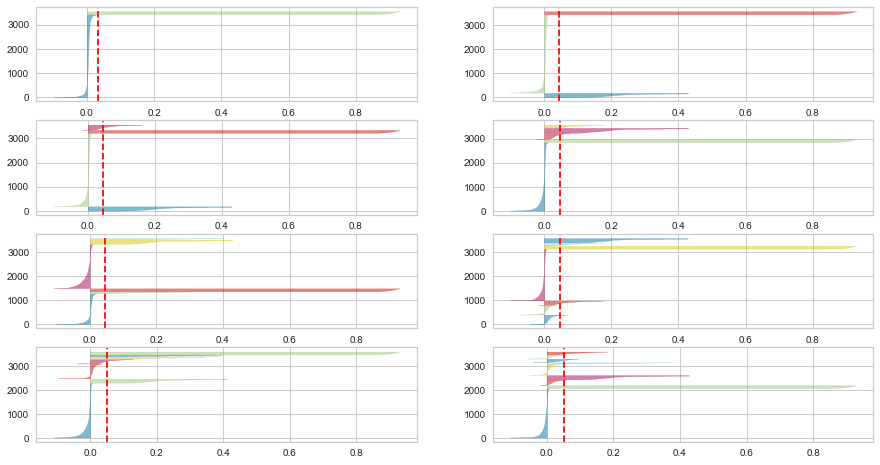

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer
cluster_range = range( 2, 10 )

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in cluster_range:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

In [13]:
print('Step 4.1. NLP preprocessing')
# get stopwords in english
normalize_corpus = np.vectorize(func_doc_preprocess)
# create corpus
corpus_01 = []
corpus_01 = temp_06['Description']
corpus_01 = np.array(corpus_01)
print("Sample Original Corpus:", corpus_01[10])    
norm_corpus_01 = normalize_corpus(corpus_01)
print("Clean Corpus:", norm_corpus_01[10])
    
# Second corpus
corpus_02 = []
corpus_02 = temp_06['combined_description']
corpus_02 = np.array(corpus_02)
print("Sample Original Corpus:", corpus_02[10])    
norm_corpus_02 = normalize_corpus(corpus_02)
print("Clean Corpus:", norm_corpus_02[10])

print('Step 4.2. Feature representative of each assignment group')
temp_08=func_feature_importance_by_class(temp_06,norm_corpus_01)

Step 4.1. NLP preprocessing
Sample Original Corpus: engineering tool says not connected and unable to submit reports
Clean Corpus: engineering tool says connected unable submit reports
Sample Original Corpus: engineering tool says not connected and unable to submit reports engineering tool says not connected and unable to submit reports
Clean Corpus: engineering tool says connected unable submit reports engineering tool says connected unable submit reports
Step 4.2. Feature representative of each assignment group

==>  GRP_0
  * Most Correlated terms are: password, unable, outlook, hostname, erp, skype, reset, need, access, issue

==>  GRP_1
  * Most Correlated terms are: hostname, space, data, sid, server, error, available, code, reporting, app

==>  GRP_2
  * Most Correlated terms are: user, sid sid, sid, hello, access, id, account, ticket, ad, provide

==>  GRP_3
  * Most Correlated terms are: pc, laptop, computer, power, need, print, working, user, work, connect

==>  GRP_4
  * Mos


==>  GRP_64
  * Most Correlated terms are: ticket, used, team, order, report, run, issue, change, open, screen

==>  GRP_65
  * Most Correlated terms are: pc, software, laptop, agent, running, computer, used, image, email, available

==>  GRP_66
  * Most Correlated terms are: hxgaycze, update, office, page, application, run, morning, click, uacyltoe, working

==>  GRP_67
  * Most Correlated terms are: complete, unable, manager, help, subject, pmto, sent, september, pmto nwfodmhc, send

==>  GRP_68
  * Most Correlated terms are: report, manager, create, required, number, following, able, time, trying, help

==>  GRP_69
  * Most Correlated terms are: business, event, user id, id, sales, ip, connection, company com, know, com

==>  GRP_70
  * Most Correlated terms are: link, create, email, company, mail, collaboration, need, platform, engineering, message

==>  GRP_71
  * Most Correlated terms are: files, team, problem, send, possible, notification, production, sent, like, know

==>  GRP

In [14]:
# Get Total count by assignment group
temp_11= temp_06.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
#consider only assignment group where total avaiable data points are more that 15
temp_11_list=temp_11[temp_11['Total_Count'] >2]['Assignment group']
temp_11=temp_06[temp_06['Assignment group'].isin(temp_11_list)]

print(temp_11.shape)
    
#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_11['Description']
    

#===================== Experiment  groups with minimum sample Size 2 =================
X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf=func_tfidx_metric(corpus_model,temp_11)
X_tr_pca, X_te_pca = func_feature_selection_pca(X_tr_tfidf, X_te_tfidf)
X_tr_chi2, X_te_chi2 = func_feature_selection_chi(X_tr_tfidf, y_tr_tfidf, X_te_tfidf)

classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

(6643, 8)
Step 6. Model Execution...


C:\Users\rajhi\anaconda3\envs\nlpmyenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



iteration                                              Model  Model_score  \
0     tfidf                                    MultinomialNB()        0.553   
1     tfidf             LogisticRegression(solver='liblinear')        0.580   
2     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.501   
3     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.579   
4     tfidf  LGBMClassifier(objective='multiclass', random_...        0.332   

   Model_recall  Model_precision  Model_f1_score   Elapsed  \
0      0.747967         0.526530           0.582  0.126181   
1      0.701818         0.563591           0.571  1.569545   
2      0.521944         0.505880           0.500  0.269294   
3      0.619968         0.533190           0.543  2.495046   
4      0.586207         0.363822           0.448  9.689690   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [15]:
classfierdict={'model': [
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
data_1=model_training(classfierdict,X_tr_pca, X_te_pca, y_tr_tfidf, y_te_tfidf,'pca')
data_1

C:\Users\rajhi\anaconda3\envs\nlpmyenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



iteration                                              Model  Model_score  \
0       pca             LogisticRegression(solver='liblinear')        0.577   
1       pca  KNeighborsClassifier(n_neighbors=3, weights='d...        0.514   
2       pca  (DecisionTreeClassifier(max_features='auto', r...        0.565   
3       pca  LGBMClassifier(objective='multiclass', random_...        0.332   

   Model_recall  Model_precision  Model_f1_score    Elapsed  \
0      0.698182         0.554038           0.567  14.905715   
1      0.533541         0.507464           0.508   0.208226   
2      0.675045         0.538932           0.553   8.693017   
3      0.413084         0.290785           0.337  56.718216   

               Model_name  
0      LogisticRegression  
1    KNeighborsClassifier  
2  RandomForestClassifier  
3          LGBMClassifier

In [16]:
classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
data_1=model_training(classfierdict,X_tr_chi2, X_te_chi2, y_tr_tfidf, y_te_tfidf,'chi2')
data_1

C:\Users\rajhi\anaconda3\envs\nlpmyenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\rajhi\anaconda3\envs\nlpmyenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



iteration                                              Model  Model_score  \
0      chi2                                    MultinomialNB()        0.532   
1      chi2             LogisticRegression(solver='liblinear')        0.561   
2      chi2  KNeighborsClassifier(n_neighbors=3, weights='d...        0.517   
3      chi2  (DecisionTreeClassifier(max_features='auto', r...        0.532   
4      chi2  LGBMClassifier(objective='multiclass', random_...        0.332   

   Model_recall  Model_precision  Model_f1_score    Elapsed  \
0      0.778022         0.555158           0.575   0.087974   
1      0.709125         0.527537           0.562   1.034594   
2      0.538341         0.459856           0.487   0.242050   
3      0.556604         0.480244           0.501   1.503753   
4      0.603825         0.405481           0.483  12.050164   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [17]:
#===================== Experiment  groups with minimum sample Size 20=================
# Get Total count by assignment group
temp_11= temp_06.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
#consider only assignment group where total avaiable data points are more that 15
temp_11_list=temp_11[temp_11['Total_Count'] >20]['Assignment group']
temp_11=temp_06[temp_06['Assignment group'].isin(temp_11_list)]

print(temp_11.shape)
    
#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_11['Description']
    

#===================== Experiment  groups with minimum sample Size 2 =================
X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf=func_tfidx_metric(corpus_model,temp_11)
X_tr_pca, X_te_pca = func_feature_selection_pca(X_tr_tfidf, X_te_tfidf)
X_tr_chi2, X_te_chi2 = func_feature_selection_chi(X_tr_tfidf, y_tr_tfidf, X_te_tfidf)

classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

(6437, 8)
Step 6. Model Execution...


iteration                                              Model  Model_score  \
0     tfidf                                    MultinomialNB()        0.565   
1     tfidf             LogisticRegression(solver='liblinear')        0.593   
2     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.531   
3     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.598   
4     tfidf  LGBMClassifier(objective='multiclass', random_...        0.604   

   Model_recall  Model_precision  Model_f1_score    Elapsed  \
0      0.752066         0.542725           0.592   0.285686   
1      0.694545         0.576380           0.578   1.542073   
2      0.537736         0.519214           0.511   0.428299   
3      0.640599         0.554477           0.569   4.440022   
4      0.642975         0.561438           0.570  13.698363   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [18]:
classfierdict={'model': [
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
data_1=model_training(classfierdict,X_tr_pca, X_te_pca, y_tr_tfidf, y_te_tfidf,'pca')
data_1

iteration                                              Model  Model_score  \
0       pca             LogisticRegression(solver='liblinear')        0.595   
1       pca  KNeighborsClassifier(n_neighbors=3, weights='d...        0.534   
2       pca  (DecisionTreeClassifier(max_features='auto', r...        0.567   
3       pca  LGBMClassifier(objective='multiclass', random_...        0.584   

   Model_recall  Model_precision  Model_f1_score    Elapsed  \
0      0.696364         0.572378           0.582  10.743801   
1      0.546032         0.519678           0.515   0.237223   
2      0.641476         0.527656           0.527   7.394717   
3      0.636210         0.571553           0.543  52.698039   

               Model_name  
0      LogisticRegression  
1    KNeighborsClassifier  
2  RandomForestClassifier  
3          LGBMClassifier

In [19]:
classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
data_1=model_training(classfierdict,X_tr_chi2, X_te_chi2, y_tr_tfidf, y_te_tfidf,'chi2')
data_1

iteration                                              Model  Model_score  \
0      chi2                                    MultinomialNB()        0.540   
1      chi2             LogisticRegression(solver='liblinear')        0.571   
2      chi2  KNeighborsClassifier(n_neighbors=3, weights='d...        0.540   
3      chi2  (DecisionTreeClassifier(max_features='auto', r...        0.542   
4      chi2  LGBMClassifier(objective='multiclass', random_...        0.540   

   Model_recall  Model_precision  Model_f1_score   Elapsed  \
0      0.814988         0.535442           0.605  0.080019   
1      0.694340         0.542578           0.562  0.681943   
2      0.557692         0.488136           0.504  0.203224   
3      0.559295         0.487391           0.506  1.039472   
4      0.564935         0.470815           0.499  6.651663   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [20]:
# Get Total count by assignment group
temp_11= temp_06.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
#consider only assignment group where total avaiable data points are more that 15
temp_11_list=temp_11[temp_11['Total_Count'] >2]['Assignment group']
temp_11=temp_06[temp_06['Assignment group'].isin(temp_11_list)]

print(temp_11.shape)
    
#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_11['combined_description']
    

#===================== Experiment  groups with minimum sample Size 2 =================
X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf=func_tfidx_metric(corpus_model,temp_11)
X_tr_pca, X_te_pca = func_feature_selection_pca(X_tr_tfidf, X_te_tfidf)
X_tr_chi2, X_te_chi2 = func_feature_selection_chi(X_tr_tfidf, y_tr_tfidf, X_te_tfidf)

classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

(6643, 8)
Step 6. Model Execution...


C:\Users\rajhi\anaconda3\envs\nlpmyenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



iteration                                              Model  Model_score  \
0     tfidf                                    MultinomialNB()        0.553   
1     tfidf             LogisticRegression(solver='liblinear')        0.580   
2     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.484   
3     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.582   
4     tfidf  LGBMClassifier(objective='multiclass', random_...        0.260   

   Model_recall  Model_precision  Model_f1_score    Elapsed  \
0      0.747967         0.523681           0.579   0.120016   
1      0.701818         0.562878           0.570   2.395516   
2      0.504702         0.504914           0.491   0.522103   
3      0.632353         0.539632           0.555   2.761306   
4      0.391403         0.284002           0.327  12.639413   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [21]:
# Get Total count by assignment group
temp_11= temp_06.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
#consider only assignment group where total avaiable data points are more that 15
temp_11_list=temp_11[temp_11['Total_Count'] >50]['Assignment group']
temp_11=temp_06[temp_06['Assignment group'].isin(temp_11_list)]

print(temp_11.shape)
    
#create corpus for modelling
normalize_corpus = np.vectorize(func_doc_preprocess)
corpus_model = temp_11['combined_description']
    

#===================== Experiment  groups with minimum sample Size 2 =================
X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf=func_tfidx_metric(corpus_model,temp_11)
X_tr_pca, X_te_pca = func_feature_selection_pca(X_tr_tfidf, X_te_tfidf)
X_tr_chi2, X_te_chi2 = func_feature_selection_chi(X_tr_tfidf, y_tr_tfidf, X_te_tfidf)

classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
print('Step 6. Model Execution...')
data_1=model_training(classfierdict,X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf,'tfidf')
data_1

(5934, 8)
Step 6. Model Execution...


iteration                                              Model  Model_score  \
0     tfidf                                    MultinomialNB()        0.608   
1     tfidf             LogisticRegression(solver='liblinear')        0.641   
2     tfidf  KNeighborsClassifier(n_neighbors=3, weights='d...        0.614   
3     tfidf  (DecisionTreeClassifier(max_features='auto', r...        0.657   
4     tfidf  LGBMClassifier(objective='multiclass', random_...        0.648   

   Model_recall  Model_precision  Model_f1_score   Elapsed  \
0      0.758403         0.579380           0.623  0.122303   
1      0.690217         0.603379           0.598  1.136808   
2      0.638112         0.588895           0.596  0.377957   
3      0.663265         0.629969           0.606  2.952974   
4      0.648148         0.624683           0.598  8.606121   

               Model_name  
0           MultinomialNB  
1      LogisticRegression  
2    KNeighborsClassifier  
3  RandomForestClassifier  
4          LGBMClassifier

In [22]:
import gensim
from gensim import corpora, models
lda_model = gensim.models.LdaMulticore(corpus_model, num_topics=10,  passes=2, workers=2)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
def main():
    start = time.perf_counter()
    print('Step 1. Getting Input Data Information...')
    temp_03 = func_read_data_n_explore("input_data.xlsx")
    print("Step 2. Data Cleaning has started...")
    temp_04 = func_clean_data(temp_03)
    print("Step 3. Detecting text language...")
    temp_04['text_lang'] = temp_04['Description'].apply(func_detect_text_language)
    # Get language name
    lang = pd.read_csv('language-codes_csv.csv')
    temp_05 = pd.merge(temp_04, lang, left_on='text_lang', right_on='alpha2', how='left') 
    temp_05=temp_05.drop_duplicates(['Short description','Description','Assignment group'])
    # Combine description and short description columns
    temp_05.loc[:,'combined_description']=temp_05['Short description'].astype(str)+' '+temp_05['Description'].astype(str)
    print(temp_05.shape)
    print("Step 4. Data Explorarion...")
    print('')
    print('Data has - {} - ticket assignment groups'.format(len(temp_03['Assignment group'].unique())))
    print('')
    print('Tickets are registered in - {} languages '.format(len(temp_04['text_lang'].unique()))) 
    print('')
    func_vis01_target_analysis(temp_04)
    print('Step 4.1. NLP preprocessing')
    # get stopwords in english
    normalize_corpus = np.vectorize(func_doc_preprocess)
    # create corpus
    corpus_01 = []
    corpus_01 = temp_05['Description']
    corpus_01 = np.array(corpus_01)
    print("Sample Original Corpus:", corpus_01[10])    
    norm_corpus_01 = normalize_corpus(corpus_01)
    print("Clean Corpus:", norm_corpus_01[10])
    
    # Second corpus
    corpus_02 = []
    corpus_02 = temp_05['combined_description']
    corpus_02 = np.array(corpus_02)
    print("Sample Original Corpus:", corpus_02[10])    
    norm_corpus_01 = normalize_corpus(corpus_02)
    print("Clean Corpus:", norm_corpus_02[10])
    
    print('Step 4.2. Feature representative of each assignment group')
    temp_08=func_feature_importance_by_class(temp_05,norm_corpus_01)
    
    # Get Total count by assignment group
    temp_11= temp_05.groupby(['Assignment group'])['Assignment group'].count().to_frame('Total_Count').reset_index()
    #consider only assignment group where total avaiable data points are more that 15
    temp_11_list=temp_11[temp_11['Total_Count'] >15]['Assignment group']
    temp_11=temp_05[temp_05['Assignment group'].isin(temp_11_list)]
    
#     #create corpus for modelling
#     normalize_corpus = np.vectorize(func_doc_preprocess)
#     corpus_model = temp_11['Description']
    
    # Feature selection
    print('Step 5. Feature selection...')
    X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf=func_tfidx_metric(corpus_model,temp_11)
    
    classfierdict={'model': [MultinomialNB(),
                             LogisticRegression(solver='liblinear'),
                             KNeighborsClassifier(n_neighbors=3,weights='distance'),
                             RandomForestClassifier(n_estimators=50, random_state=42),
                             LGBMClassifier(objective='multiclass', random_state=5)]}
    
    print('Step 6. Model Execution...')
    data_1=model_training(classfierdict,X_tr_tfidf, X_te_tfidf, y_tr_tfidf, y_te_tfidf,'tfidf')
    
    
    X_tr_pca, X_te_pca = func_feature_selection_pca(X_tr_tfidf, X_te_tfidf)
    X_tr_chi2, X_te_chi2 = func_feature_selection_chi(X_tr_tfidf, y_tr_tfidf, X_te_tfidf)
    
    finish = time.perf_counter()
    print(f'Total Execution Time: Finished in {round(finish-start, 2)} second(s)')
    return temp_05, norm_corpus,temp_08,data_1
